# Advanced Feature Engineering

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Advanced-Feature-Engineering" data-toc-modified-id="Advanced-Feature-Engineering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Advanced Feature Engineering</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#LyricsManager.py" data-toc-modified-id="LyricsManager.py-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LyricsManager.py</a></span></li><li><span><a href="#MoodyLyrics-issue" data-toc-modified-id="MoodyLyrics-issue-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MoodyLyrics issue</a></span></li><li><span><a href="#New-features" data-toc-modified-id="New-features-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>New features</a></span><ul class="toc-item"><li><span><a href="#Dataset-Stats" data-toc-modified-id="Dataset-Stats-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Dataset Stats</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Feature Selection</a></span><ul class="toc-item"><li><span><a href="#Extra-test-set" data-toc-modified-id="Extra-test-set-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Extra test set</a></span></li></ul></li></ul></li><li><span><a href="#Dimensionality-Reduction" data-toc-modified-id="Dimensionality-Reduction-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Dimensionality Reduction</a></span></li><li><span><a href="#Classification" data-toc-modified-id="Classification-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Artificial-Neural-Network" data-toc-modified-id="Artificial-Neural-Network-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Artificial Neural Network</a></span><ul class="toc-item"><li><span><a href="#Playlist-Classification" data-toc-modified-id="Playlist-Classification-7.1.1"><span class="toc-item-num">7.1.1&nbsp;&nbsp;</span>Playlist Classification</a></span></li></ul></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#Playlist-Classification" data-toc-modified-id="Playlist-Classification-7.2.1"><span class="toc-item-num">7.2.1&nbsp;&nbsp;</span>Playlist Classification</a></span></li></ul></li><li><span><a href="#SVM" data-toc-modified-id="SVM-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#eXtreme-Gradient-Boost" data-toc-modified-id="eXtreme-Gradient-Boost-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>eXtreme Gradient Boost</a></span></li><li><span><a href="#Naive-Bayesian-Classifier" data-toc-modified-id="Naive-Bayesian-Classifier-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Naive Bayesian Classifier</a></span><ul class="toc-item"><li><span><a href="#Playlist-Classification" data-toc-modified-id="Playlist-Classification-7.5.1"><span class="toc-item-num">7.5.1&nbsp;&nbsp;</span>Playlist Classification</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [252]:
import spacy
import os
import sys
import warnings
import itertools

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from utils.datasets import load_dataset_from_path, split_train_validation

emotion_labels = ['happy', 'sad', 'angry', 'relaxed']

use_both = True

In [253]:
# Read extra test set
extra_test_path = './datasets/extra_test.csv'
extra_test = pd.read_csv(extra_test_path)

In [254]:
def plot_confusion_matrix(cm, classes = emotion_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [255]:
def plot_pca_exp_var(x, dim):
    '''
    Utility function used to plot the explained variance
    variation by doing dimensionality reduction
    '''
    # Perform PCA and get explained variance
    pca = PCA(n_components=dim)
    x_pca = pca.fit_transform(x)
    exvar = (pca.explained_variance_ratio_)
    exvar.sort()
    exvar = exvar[::-1]
    
    # Compute CDF
    cdf = np.zeros_like(exvar)
    for i in range(len(exvar)):
        cdf[i] = exvar[0] if i == 0 else cdf[i-1]+exvar[i]
    cdf = np.insert(cdf, 0, 0)
    
    # Plot
    ax = plt.gca()

    # Find point in which we have 75% information
    f = np.where(cdf >= 0.75)[0][0]
    ax.axhline(0.75, color='orange', linestyle='-.',lw=2, alpha=0.5)
    ax.axvline(f, linestyle='-.', color='orange', lw=2, alpha=0.5)
    ax.text(f+5, 0.1, '%s features' % f)

    # Find point in which we have 99% information
    f = np.where(cdf >= 0.99)[0][0]
    ax.axhline(0.99, color='green', linestyle='-.',lw=2, alpha=0.5)
    ax.axvline(f, linestyle='-.', color='green', lw=2, alpha=0.5)
    ax.text(f+5, 0.1, '%s features' % f)

    plt.title('Explained Variance')
    plt.xlabel('Number of Components')
    plt.plot(np.arange(dim + 1), cdf, lw=2.5)
    plt.show()

# Introduction
**Previously on Sara&Mario project**: 
<ol>
    <li>*MoodyLyrics* stats analysis</li>
    <li>Lyrics classification using the main classifiers</li>
    <li>Emotion classification by just considering the song title</li> 
</ol>
Now, following the last meeting discussion we: 
<ol>
    <li>Wrote a script to create the dataset *SpotifyURI*, *List of PlaylistIDs*, *MoodyLyric_Emotion*</li>
    <li>Wrote a script to detect all duplicated songs in MoodyLyrics to fill a bug report</li>
    <li>Added new features for the classification task</li>
</ol>

# LyricsManager.py
After downloading the Spotify RecSys Challenge dataset we wrote a script that: <br>
<ul>
    <li>Given as input: the *Spotify playlist dataset folder*, and an output folder, creates a data structure to store for each song:<br>
        <*SpotifyURI*, *PlaylistIDs*, *TrackInformation*, *Emotion*><br>
        where: 
            <ul>
                <li>*SpotifyURI* is the songID</li>
                <li>*PlaylistsIDs* is the list of playlist in which the song appear</li>
                <li>*TrackInformation* is the list of information taken from Spotify dataset</li>
                <li>*Emotion* is an optional field, present only if the song is also contained in the MoodyLyrics dataset, that contains the emotion label for the song
    </li>
            </ul>
      <li>Can load Spotify songs datastructure (if already existing)</li>
            <li>Given as input a SpotifyURI it can download lyrics from lyricwikia</li>
</ul>

# MoodyLyrics issue
New week we detected duplicate information in MoodyLyrics. Now we can generate a .csv file capable of reporting those duplicates.

Now it's time to fill a bug.

# New features
Starting from MoodyLyrics we are going to create a new dataset with a lot of new features. <br>
<ul>
    <li>**Title_vector**</li>
    <li>**Lyric_vector**</li>
    <li>**%Rhymes**:<br> defined as the percentage of the number of rhymes over the number of total lines. A rhyme is defined as a rhyme between two following lines.</li>
    <li>**%Past_tense_verbs**:<br> defined as the the percentage of the number of past tense verbs over the total number of verbs.</li>
    <li>**%Present_tense_verbs**:<br>  defined as the the percentage of the number of present tense verbs over the total number of verbs.</li>
    <li>**%Future_tense_verbs**:<br>  defined as the the percentage of the number of future tense verbs over the total number of verbs, where future is just will + base form.</li>
    <li>**%ADJ**:<br> Percentage of adjectives over the total number of words.</li>
    <li>**%ADP**:<br> Percentage of adpositions (e.g. in, to, during) over the total number of words.</li>
    <li>**%ADV**:<br> Percentage of adverbs (e.g. very, tomorrow, down, where, there) over the total number of words.</li>
    <li>**%AUX**:<br> Percentage of auxiliaries (e.g. is, has (done), will (do), should (do)) over the total number of words.</li>
    <li>**%INTJ**:<br> Percentage of interjections (e.g. psst, ouch, bravo, hello) over the total number of words.</li>
    <li>**%NOUN**:<br> Percentage of nouns over the total number of words.</li>
    <li>**%NUM**:<br> Percentage of numerals over the total number of words.</li>
    <li>**%PRON**:<br> Percentage of pronouns (e.g. I, you, he, she, myself, themselves, somebody,...) over the total number of words.</li> 
    <li>**%PROPN**:<br> Percentage of proper nouns (e.g. Mary, John) over the total number of words.</li>
    <li>**%PUNCT**:<br> Percentage of puntuctuation (e.g. ., (, ), ?) over the total number of words.</li>
    <li>**%VERB**:<br> Percentage of verbs over the total number of words.</li>
    <li>**Selfish_degree**:<br> Percentage of 'I' pronouns over the total number of pronouns</li>
    <li>**%Echoism**:<br> Percentage of echoism over the total number of words, where an echoism is either a sequence of two subsequent repeated words or the repetition of a vowel in a word. </li>
    <li>**%Duplicates**:<br> Percentage of duplicate words over the total number of words</li>
    <li>**isTitleInLyric**:<br> Boolean, true if the title string is also a substring of the lyric</li>
    <li>**sentiment**:<br> Sentiment between -1 and 1</li>
    <li>**subjectivity degree**:<br> Degree of subjectivity of the text</li>
</ul>

The sentiment and subjectivity analysis was done using [TextBlob](http://textblob.readthedocs.io/en/dev/index.html) Python NLP library.

## Dataset Stats

In [256]:
import pandas as pd

In [257]:
dataset = pd.read_csv('./datasets/moodylyrics4q_featurized.csv')
if use_both:
    dataset2 = pd.read_csv('./datasets/moodylyrics_featurized.csv')
    l = len(dataset) + len(dataset2)
    dataset = pd.concat([dataset, dataset2])
    dataset.drop_duplicates(['ARTIST', 'SONG_TITLE'], inplace=True)
    print('Columns contained in both datasets:',l - len(dataset))

Columns contained in both datasets: 46


In [258]:
useless_columns = [ 'ID','ARTIST', 'SONG_TITLE', 'EMOTION', 'X_FREQUENCIES', 'SPACE_FREQUENCIES']

In [259]:
print(len(dataset.columns))

38


In [260]:
dataset.head(5)

,Unnamed: 0,ID,ARTIST,SONG_TITLE,LYRICS_VECTOR,TITLE_VECTOR,LINE_COUNT,WORD_COUNT,ECHOISMS,SELFISH_DEGREE,...,PROPN_FREQUENCIES,PUNCT_FREQUENCIES,SCONJ_FREQUENCIES,SYM_FREQUENCIES,VERB_FREQUENCIES,X_FREQUENCIES,SPACE_FREQUENCIES,SENTIMENT,SUBJECTIVITY,EMOTION
0,0,0,George Michael,I Want Your Sex,[-5.66669777e-02 1.93739146e-01 -2.36738548e-...,[-4.32439968e-02 2.35226482e-01 -3.88222516e-...,71,368,0.000000,0.317647,...,0.005435,0.040761,0.0,0.0,0.334239,0.0,0.000000,0.194792,0.497917,happy
1,1,1,Rob Zombie,Pussy Liquor,[-1.04138955e-01 1.12780936e-01 -1.97507262e-...,[-2.96456993e-01 -4.45510000e-01 1.91705018e-...,70,353,0.000000,0.488372,...,0.042493,0.186969,0.0,0.0,0.274788,0.0,0.000000,-0.432963,0.623796,angry
2,2,2,Katatonia,12,[ 2.06664652e-02 1.38426125e-01 -1.25962764e-...,[-4.9697e-01 7.5841e-01 5.5408e-01 -2.1904e-...,20,88,0.000000,0.400000,...,0.022727,0.000000,0.0,0.0,0.215909,0.0,0.000000,0.083333,0.570833,sad
3,3,3,Bing Crosby,Swinging On A Star,[-5.10253236e-02 1.10397667e-01 -1.82846352e-...,[ 2.16670498e-01 5.32097518e-02 -1.99138999e-...,36,285,0.000000,0.000000,...,0.000000,0.024561,0.0,0.0,0.252632,0.0,0.000000,-0.063312,0.628247,happy
4,4,4,Ludacris,Get Back,[-4.41129357e-02 1.29719913e-01 -1.68546975e-...,[ 4.08100039e-02 1.84709996e-01 -3.87395024e-...,92,773,0.020699,0.363636,...,0.055627,0.107374,0.0,0.0,0.240621,0.0,0.006468,-0.002072,0.353314,angry


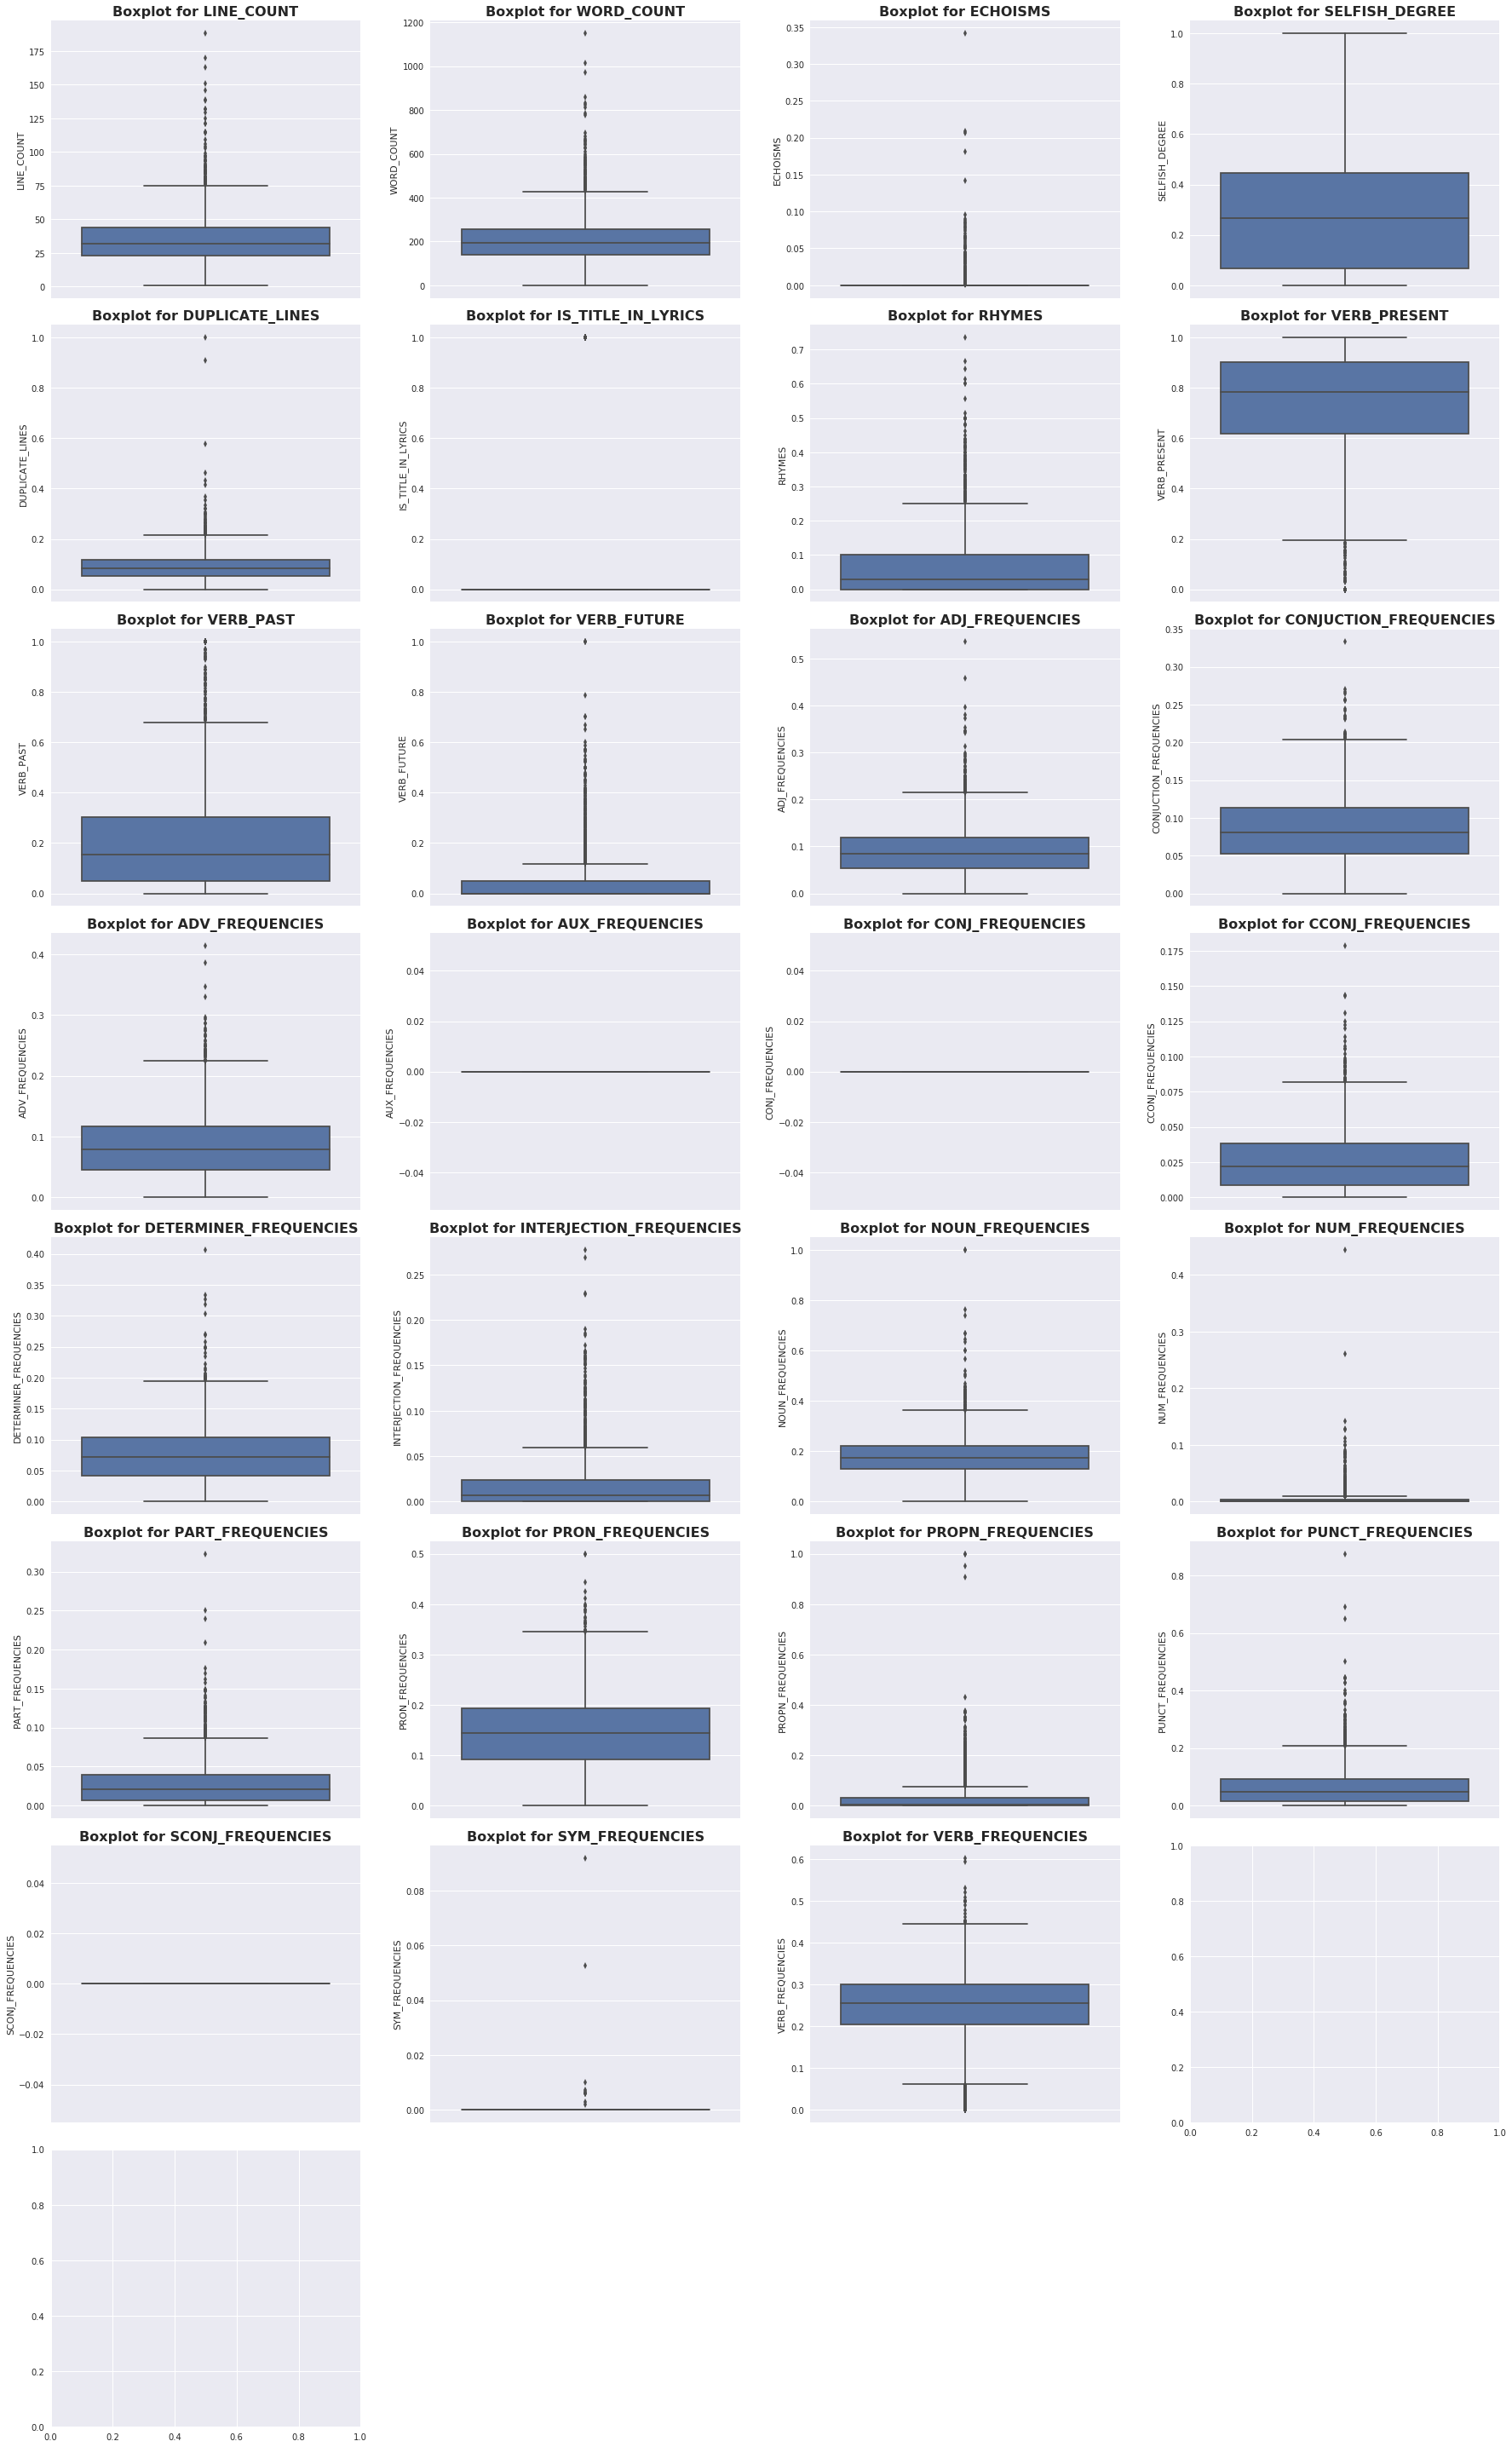

In [12]:
tmp_df = dataset.drop(useless_columns + ['LYRICS_VECTOR', 'TITLE_VECTOR'],axis=1)

f, axarr = plt.subplots(8, 4, figsize=(25,40))
k = 0
for feature in tmp_df.columns:
    (i, j) = divmod(k, 4)
    axarr[i,j] = sns.boxplot(y=tmp_df[feature], ax=axarr[i,j])
    axarr[i,j].set_title('Boxplot for {}'.format(feature), fontsize=16, weight='bold')
    k += 1
plt.tight_layout()
f.delaxes(axarr[-1,-1])
f.delaxes(axarr[-1,-2])
f.delaxes(axarr[-1,-3])

## Feature Selection

In [261]:
selected_columns = [
   'LYRICS_VECTOR',
   #'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   #'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   #'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   #'PUNCT_FREQUENCIES',
   #'SENTIMENT', 'SUBJECTIVITY',
   'EMOTION'
]

In [262]:
dataset = dataset[selected_columns]
extra_test = extra_test[selected_columns]

In [263]:
tmp_df = dataset.drop(['EMOTION'], axis=1)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)

In [264]:
y = dataset['EMOTION'].as_matrix().T

In [265]:
print(X_vect.shape)
print(y.shape)

(4378, 300)
(4378,)


In [266]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size = 0.1, random_state = 13)

### Extra test set

In [267]:
tmp_df = extra_test.drop(['EMOTION'], axis=1)
X_test_extra = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X_test_extra.append(np.array(sub_list))
X_test_extra = np.array(X_test_extra)

In [268]:
y_test_extra = extra_test['EMOTION'].as_matrix().T

# Dimensionality Reduction

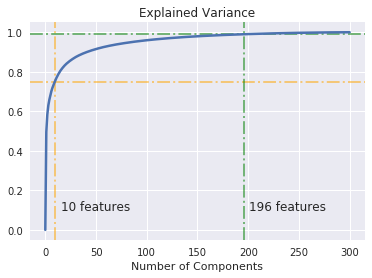

In [269]:
plot_pca_exp_var(X_train, X_train.shape[1])

In [270]:
pca = PCA(n_components=195)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_test_extra_pca = pca.transform(X_test_extra)

# Classification

## Artificial Neural Network

In [271]:
from keras.utils import np_utils

## Encode outputs

encoder = LabelEncoder()

encoder.fit(y_train)

encoded_Y_train = encoder.transform(y_train)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_test_extra = encoder.transform(y_test_extra)
y_train_nn = np_utils.to_categorical(encoded_Y_train)
y_test_nn = np_utils.to_categorical(encoded_Y_test)
y_test_extra_nn = np_utils.to_categorical(encoded_Y_test_extra)

In [272]:
cm_labels = encoder.inverse_transform([0, 1, 2, 3])

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [273]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

## Scale inputs

sc = MinMaxScaler(feature_range=(0,1))

sc.fit(X_train_pca)

X_train_nn = sc.transform(X_train_pca)
X_test_nn = sc.transform(X_test_pca)
X_test_extra_nn = sc.transform(X_test_extra_pca)

In [363]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
    
from sklearn.utils import class_weight
    
def build_ann(optimizer='adam', input_size=X_vect.shape[1]):
    classifier = Sequential()
    
    # Add input layer
    classifier = Sequential()
    # Add input layer
    classifier.add(Dense(units = 2000, kernel_initializer = 'random_normal', activation = 'tanh', input_dim = input_size))
    classifier.add(Dropout(0.5))
    
    # Add hidden layers
    #classifier.add(Dense(units = 150, kernel_initializer = 'random_normal', activation = 'tanh'))
    #classifier.add(Dropout(0.5))
                
    #classifier.add(Dense(units = 150, kernel_initializer = 'random_normal', activation = 'sigmoid'))
    #classifier.add(Dropout(0.5))
        
    # Add output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'random_normal', activation = 'softmax'))
    
    # Compiling the ANN
    classifier.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [364]:
from keras.callbacks import EarlyStopping

classifier = build_ann('adam', X_train_nn.shape[1])
early_stop = EarlyStopping(monitor='val_acc', min_delta=1e-5, patience=5, verbose=1, mode='auto')

classifier.fit(X_train_nn, y_train_nn, batch_size = 256, epochs = 1000, 
               validation_split=0.1, callbacks=[early_stop], verbose=False)

Epoch 00017: early stopping


In [365]:
y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

Accuracy: 52.28


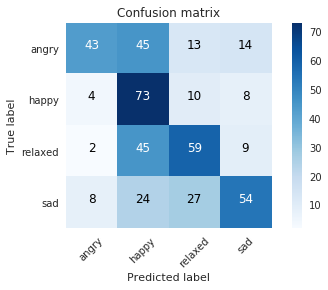

In [366]:
cm = confusion_matrix(encoded_Y_test, y_pred)
plot_confusion_matrix(cm, classes=cm_labels)
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(y_pred)
print('Accuracy: %0.2f' % (accuracy*100))

In [290]:
y_pred_extra = classifier.predict(X_test_extra_nn)
y_pred_extra = np.argmax(y_pred_extra, axis=1)

Accuracy: 45.00


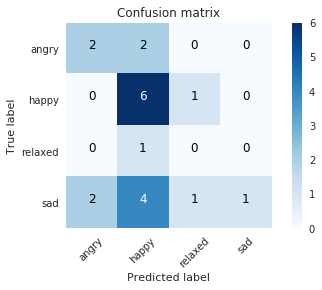

In [584]:
cm = confusion_matrix(encoded_Y_test_extra, y_pred_extra)
plot_confusion_matrix(cm, classes=cm_labels)
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(encoded_Y_test_extra)
print('Accuracy: %0.2f' % (accuracy*100))

In [25]:
extra_test = pd.read_csv(extra_test_path)
for (idx, row) in extra_test.iterrows():
    print('Prediction for: "{}" from "{}"'.format(row['SONG_TITLE'], row['ARTIST']))
    print('\t - {}'.format(encoder.inverse_transform(y_pred_extra[idx])))

Prediction for: "Don't Worry, Be Happy" from "Bobby McFerrin"
	 - angry
Prediction for: "Don't Stop me Now" from "Queen"
	 - angry
Prediction for: "Happy" from "Pharrell Williams"
	 - angry
Prediction for: "I'm a believer" from "The Monkees"
	 - happy
Prediction for: "Toxic" from "Britney Spears"
	 - happy
Prediction for: "Buttons" from "The Pussycat Dolls"
	 - angry
Prediction for: "Crazy In Love" from "Beyoncé"
	 - happy
Prediction for: "Everybody Hurts" from "R.E.M."
	 - angry
Prediction for: "Someone Like You" from "Adele"
	 - angry
Prediction for: "Wish you were here" from "Pink Floyd"
	 - relaxed
Prediction for: "Hurt" from "Johnny Cash"
	 - relaxed
Prediction for: "Smells like teen spirit" from "Nirvana"
	 - angry
Prediction for: "My Boo" from "Usher"
	 - happy
Prediction for: "Rock Your Body" from "Justin Timberlake"
	 - angry
Prediction for: "It Wasn't Me" from "Shaggy"
	 - happy
Prediction for: "Killing in the name" from "Rage Against the Machine"
	 - angry
Prediction for: "S

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

### Playlist Classification

In [26]:
import json

n_pl = 3

data = json.load(open('./datasets/mpd.slice.0-999.json'))
playlists = data['playlists'][:n_pl]

In [27]:
from utils.dataset_parsing import *
import utils.sentiment_analysis as sa

KeyboardInterrupt: 

In [ ]:
def featurize(lyrics, pid, playlist_name, artist, title):
    lyric_doc = nlp(lyrics)
    title_doc = nlp(title)
    lyric = preprocess(lyrics)
    features = feature_extraction(lyric, title)

    freq = features['frequencies'] 
    sentiment = sa.analyse(lyrics)
    elem = [
        pid, playlist_name, 0, artist, title,
        lyric_doc.vector, title_doc.vector,
        features['line_count'], features['word_count'],#get_line_count(lyric), get_word_count(lyric),
        #get_slang_counts(lyric),
        features['echoisms'], features['selfish'],#get_echoisms(lyric), get_selfish_degree(lyric),
        count_duplicate_lines(lyric), features['is_title_in_lyrics'],# (row['Song'], lyric),
        features['rhymes'],#get_rhymes(lyric),
        features['verb_tenses']['present'], features['verb_tenses']['past'], features['verb_tenses']['future'], #verb_freq['present'], verb_freq['past'], verb_freq['future'],
        freq['ADJ'], freq['ADP'], freq['ADV'], freq['AUX'], freq['CONJ'], 
        freq['CCONJ'], freq['DET'], freq['INTJ'], freq['NOUN'], freq['NUM'],
        freq['PART'], freq['PRON'], freq['PROPN'], freq['PUNCT'], freq['SCONJ'],
        freq['SYM'], freq['VERB'], freq['X'], freq['SPACE'],
        # Sentiment analysis stuff
        sentiment[0], sentiment[1]
    ]
    return elem

In [ ]:
import lyricwikia

In [ ]:
features = list()
for playlist in playlists:
    for track in playlist['tracks']:
        artist = track['artist_name']
        title = track['track_name']
        try:
            lyrics = lyricwikia.get_lyrics(artist, title)
            x = featurize(lyrics, playlist['pid'], 'Test', artist, title)
            features.append(x)
        except lyricwikia.LyricsNotFound:
             continue
    df = pd.DataFrame(features, columns=['PlaylistPid','PlaylistName','TrackUri', 'ArtistName', 'TrackName','LYRICS_VECTOR', 'TITLE_VECTOR', 
            'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
            'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
            'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
            'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
            'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
            'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
            'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
            'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
            'SENTIMENT', 'SUBJECTIVITY'])
df.head(3)

In [ ]:
tmp_df = df[[
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY']]#.drop(['PlaylistPid', 'PlaylistName', 'TrackUri', 'ArtistName', 'TrackName'], axis=1, inplace=True)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == np.ndarray:
            sub_list += [float(x) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)
X_vect.shape

In [ ]:
X_vect_nn = sc.transform(X_vect)

In [ ]:
y_pred = classifier.predict(X_vect_nn, verbose=0)

In [ ]:
classificationDf = pd.DataFrame(data=y_pred,columns=cm_labels)
finalDf = pd.concat([df, classificationDf],axis=1)

In [ ]:
finalDf[cm_labels].head(5)

In [ ]:
map_mean = dict()
for emo in cm_labels:
    map_mean[emo] = 'mean'
playlistDf = finalDf.groupby(by='PlaylistPid').agg(map_mean)

In [ ]:
playlistDf.head(n_pl)

## Logistic Regression

In [138]:
from sklearn.linear_model import LogisticRegression
def evaluate_logreg(X_train, y_train, X_test, y_test):
    classifier = LogisticRegression(penalty='l2', dual=False, C=25,
                                    solver='newton-cg', multi_class='multinomial', random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=cm_labels)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.55


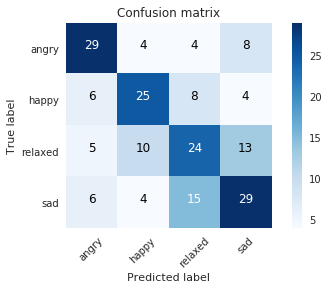

In [140]:
evaluate_logreg(X_train, y_train, X_test, y_test)

Accuracy of logistic regression classifier on test set: 0.40


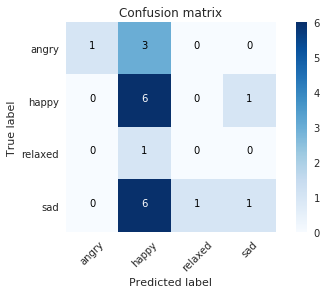

In [65]:
evaluate_logreg(X_train, y_train, X_test_extra, y_test_extra)

### Playlist Classification

In [ ]:
clf = LogisticRegression(penalty='l2', dual=False, C=0.15, 
                         solver='newton-cg', multi_class='multinomial', random_state=0)
clf.fit(X_train, y_train)

In [ ]:
import json

n_pl = 5

data = json.load(open('./datasets/mpd.slice.0-999.json'))
playlists = data['playlists'][:n_pl]

In [ ]:
from utils.dataset_parsing import *
import utils.sentiment_analysis as sa

In [ ]:
def featurize(lyrics, pid, playlist_name, artist, title):
    lyric_doc = nlp(lyrics)
    title_doc = nlp(title)
    lyric = preprocess(lyrics)
    features = feature_extraction(lyric, title)

    freq = features['frequencies'] 
    sentiment = sa.analyse(lyrics)
    elem = [
        pid, playlist_name, 0, artist, title,
        lyric_doc.vector, title_doc.vector,
        features['line_count'], features['word_count'],#get_line_count(lyric), get_word_count(lyric),
        #get_slang_counts(lyric),
        features['echoisms'], features['selfish'],#get_echoisms(lyric), get_selfish_degree(lyric),
        count_duplicate_lines(lyric), features['is_title_in_lyrics'],# (row['Song'], lyric),
        features['rhymes'],#get_rhymes(lyric),
        features['verb_tenses']['present'], features['verb_tenses']['past'], features['verb_tenses']['future'], #verb_freq['present'], verb_freq['past'], verb_freq['future'],
        freq['ADJ'], freq['ADP'], freq['ADV'], freq['AUX'], freq['CONJ'], 
        freq['CCONJ'], freq['DET'], freq['INTJ'], freq['NOUN'], freq['NUM'],
        freq['PART'], freq['PRON'], freq['PROPN'], freq['PUNCT'], freq['SCONJ'],
        freq['SYM'], freq['VERB'], freq['X'], freq['SPACE'],
        # Sentiment analysis stuff
        sentiment[0], sentiment[1]
    ]
    return elem

In [ ]:
import lyricwikia

In [ ]:
features = list()
for playlist in playlists:
    for track in playlist['tracks']:
        artist = track['artist_name']
        title = track['track_name']
        try:
            lyrics = lyricwikia.get_lyrics(artist, title)
            x = featurize(lyrics, playlist['pid'], 'Test', artist, title)
            features.append(x)
        except lyricwikia.LyricsNotFound:
             continue
    df = pd.DataFrame(features, columns=['PlaylistPid','PlaylistName','TrackUri', 'ArtistName', 'TrackName','LYRICS_VECTOR', 'TITLE_VECTOR', 
            'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
            'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
            'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
            'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
            'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
            'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
            'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
            'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
            'SENTIMENT', 'SUBJECTIVITY'])
df.head(3)

In [ ]:
tmp_df = df[[
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY']]#.drop(['PlaylistPid', 'PlaylistName', 'TrackUri', 'ArtistName', 'TrackName'], axis=1, inplace=True)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == np.ndarray:
            sub_list += [float(x) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)
X_vect.shape

In [ ]:
y_pred = clf.predict_proba(X_vect)

In [ ]:
classificationDf = pd.DataFrame(data=y_pred,columns=cm_labels)
finalDf = pd.concat([df, classificationDf],axis=1)

In [ ]:
finalDf[['angry', 'happy', 'relaxed', 'sad']].head(5)

In [ ]:
playlistDf = finalDf.groupby(by='PlaylistPid').agg({'happy': 'mean', 'sad': 'mean', 'angry': 'mean', 'relaxed': 'mean'})

In [ ]:
playlistDf.head(n_pl)

## SVM 

In [278]:
def parameters_grid_search(classifier, params, x, y, cv=10, verbose=False):
    """
    Grid Search to find best parameters for a certain classifier whose
    performances are evaluated using cross-validation
    """
    gs = GridSearchCV(classifier(), params, cv=cv, n_jobs=-1, verbose=verbose)
    gs.fit(x, y)    
    return (gs.best_estimator_, gs.best_params_)

In [279]:
from sklearn.svm import SVC

In [367]:
clf = SVC(C=220, kernel='rbf')
clf.fit(X_train_pca, y_train)

SVC(C=220, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy of SVM classifier on test set: 0.69


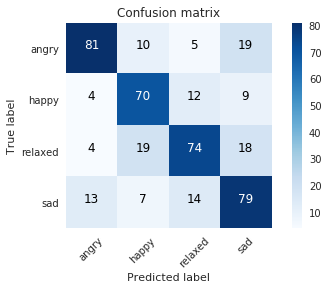

In [368]:
y_pred = clf.predict(X_test_pca)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=cm_labels)
print('Accuracy of SVM classifier on test set: {:.2f}'.format(clf.score(X_test_pca, y_test)))

Accuracy of SVM classifier on extra test set: 0.60


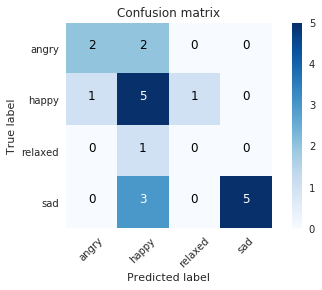

In [370]:
y_pred_extra = clf.predict(X_test_extra_pca)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred_extra), classes=cm_labels)
print('Accuracy of SVM classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra_pca, y_test_extra)))

## eXtreme Gradient Boost

In [121]:
import xgboost

In [126]:
xgb = xgboost.XGBClassifier(n_estimators=100,
                            learning_rate=0.2,
                            base_score=2,
                            max_depth = 3,
                            colsample_bytree=1,
                            booster='dart',
                            objective='multi:softmax')
xgb.fit(X_train_pca, y_train)

XGBClassifier(base_score=2, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [127]:
predictions = xgb.predict(X_test_pca)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 51.03%


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Naive Bayesian Classifier

In [129]:
from sklearn.preprocessing import MinMaxScaler

## Scale inputs

sc = MinMaxScaler((0,1))

sc.fit(X_train_pca)

X_train_nb = sc.transform(X_train_pca)
X_test_nb = sc.transform(X_test_pca)
X_test_extra_nb = sc.transform(X_test_extra_pca)

In [130]:
from sklearn.naive_bayes import MultinomialNB

In [136]:
clf = MultinomialNB()
clf.fit(X_train_nb, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Accuracy of Naive-Bayes classifier on test set: 0.46


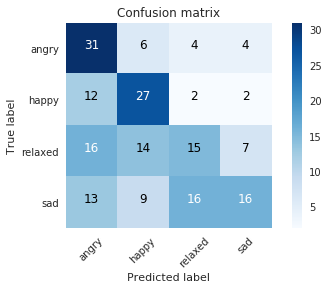

In [137]:
y_pred = clf.predict(X_test_nb)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=cm_labels)
print('Accuracy of Naive-Bayes classifier on test set: {:.2f}'.format(clf.score(X_test_nb, y_test)))

Accuracy of Naive-Bayes classifier on extra test set: 0.55


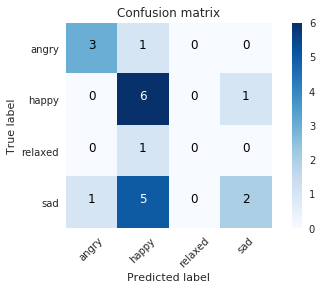

In [133]:
y_pred = clf.predict(X_test_extra_nb)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred), classes=cm_labels)
print('Accuracy of Naive-Bayes classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra_nb, y_test_extra)))

### Playlist Classification

In [ ]:
import json

n_pl = 5

data = json.load(open('./datasets/mpd.slice.0-999.json'))
playlists = data['playlists'][:n_pl]

In [ ]:
from utils.dataset_parsing import *
import utils.sentiment_analysis as sa

In [ ]:
def featurize(lyrics, pid, playlist_name, artist, title):
    lyric_doc = nlp(lyrics)
    title_doc = nlp(title)
    lyric = preprocess(lyrics)
    features = feature_extraction(lyric, title)

    freq = features['frequencies'] 
    sentiment = sa.analyse(lyrics)
    elem = [
        pid, playlist_name, 0, artist, title,
        lyric_doc.vector, title_doc.vector,
        features['line_count'], features['word_count'],#get_line_count(lyric), get_word_count(lyric),
        #get_slang_counts(lyric),
        features['echoisms'], features['selfish'],#get_echoisms(lyric), get_selfish_degree(lyric),
        count_duplicate_lines(lyric), features['is_title_in_lyrics'],# (row['Song'], lyric),
        features['rhymes'],#get_rhymes(lyric),
        features['verb_tenses']['present'], features['verb_tenses']['past'], features['verb_tenses']['future'], #verb_freq['present'], verb_freq['past'], verb_freq['future'],
        freq['ADJ'], freq['ADP'], freq['ADV'], freq['AUX'], freq['CONJ'], 
        freq['CCONJ'], freq['DET'], freq['INTJ'], freq['NOUN'], freq['NUM'],
        freq['PART'], freq['PRON'], freq['PROPN'], freq['PUNCT'], freq['SCONJ'],
        freq['SYM'], freq['VERB'], freq['X'], freq['SPACE'],
        # Sentiment analysis stuff
        sentiment[0], sentiment[1]
    ]
    return elem

In [ ]:
import lyricwikia

In [ ]:
features = list()
for playlist in playlists:
    for track in playlist['tracks']:
        artist = track['artist_name']
        title = track['track_name']
        try:
            lyrics = lyricwikia.get_lyrics(artist, title)
            x = featurize(lyrics, playlist['pid'], 'Test', artist, title)
            features.append(x)
        except lyricwikia.LyricsNotFound:
             continue
    df = pd.DataFrame(features, columns=['PlaylistPid','PlaylistName','TrackUri', 'ArtistName', 'TrackName','LYRICS_VECTOR', 'TITLE_VECTOR', 
            'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
            'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
            'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
            'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
            'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
            'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
            'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
            'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
            'SENTIMENT', 'SUBJECTIVITY'])
df.head(3)

In [ ]:
tmp_df = df[[
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY']]#.drop(['PlaylistPid', 'PlaylistName', 'TrackUri', 'ArtistName', 'TrackName'], axis=1, inplace=True)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == np.ndarray:
            sub_list += [float(x) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)
X_vect.shape

In [ ]:
X_vect_scaled = sc.transform(X_vect)

In [ ]:
y_pred = clf.predict_proba(X_vect_scaled)

In [ ]:
classificationDf = pd.DataFrame(data=y_pred,columns=cm_labels)
finalDf = pd.concat([df, classificationDf],axis=1)

In [ ]:
finalDf[['angry', 'happy', 'relaxed', 'sad']].head(5)

In [ ]:
playlistDf = finalDf.groupby(by='PlaylistPid').agg({'happy': 'mean', 'sad': 'mean', 'angry': 'mean', 'relaxed': 'mean'})

In [ ]:
playlistDf.head(n_pl)

# Conclusion
- The neural network is certainly the best classifier for our purpose
- We are always quite good at classifying sad songs but we often lack in performances while classifying other emotions